In [1]:
import pandas as pd

In [6]:
mvps = pd.read_csv('mvps.csv')
mvps = mvps[['Player', 'Year', 'Pts Won', 'Pts Max', 'Share']] # only need these columns from mvp csv (rest are in players.csv)

In [7]:
players = pd.read_csv('players.csv')
del players['Unnamed: 0']
del players['Rk']

In [8]:
players['Player'] = players['Player'].str.replace('*', '', regex=False) # cleaning * from player names


In [9]:
# function to only keep total stats
def get_single_row(player_group):
  if player_group.shape[0] == 1: return player_group

  total_row = player_group[player_group['Tm'] == 'TOT']
  total_row["Tm"] = player_group.iloc[-1,:]['Tm']
  return total_row

players = players.groupby(['Player', 'Year']).apply(get_single_row)

In [10]:
players.index = players.index.droplevel()
players.index = players.index.droplevel() 

In [11]:
# outer merge allows us to keep data of players and years not in mvps
comb = players.merge(mvps, how='outer', on=['Player', 'Year'])

In [12]:
# need to clean up NaN
comb[['Pts Won', 'Pts Max', 'Share']] = comb[['Pts Won', 'Pts Max', 'Share']].fillna(0)

In [13]:
# cleaning the team data
teams = pd.read_csv('teams.csv')
teams = teams[~teams["W"].str.contains("Division")]
teams['Team'] = teams['Team'].str.replace('*', '', regex=False)

In [14]:
# need to change full names to nicknames in Teams
nicknames = {}

with open('nicknames.txt') as f:
  lines = f.readlines()
  for line in lines[1:]:
    abbr, name = line.replace('\n', '').split(',')
    nicknames[abbr] = name

In [15]:
comb['Team'] = comb['Tm'].map(nicknames)

In [16]:
stats = comb.merge(teams, how='outer', on=['Team', 'Year'])

In [17]:
del stats['Unnamed: 0']

In [18]:
stats = stats.apply(pd.to_numeric, errors='ignore')

In [19]:
stats['GB'] = stats['GB'].str.replace('—', '0') # note this dash is different from keyboard dash
stats['GB'].unique()

array(['5.0', '14.0', '23.0', '7.0', '0', '40.0', '42.0', '18.0', '6.0',
       '24.0', '26.0', '37.0', '29.0', '21.0', '28.0', '25.0', '8.0',
       '19.0', '1.0', '13.0', '17.0', '3.0', '15.0', '9.0', '2.0', '35.0',
       '20.0', '11.0', '16.0', '41.0', '12.0', '50.0', '10.0', '30.0',
       '34.0', '4.0', '1.5', '22.0', '51.0', '36.0', '43.0', '39.0',
       '18.5', '48.0', '46.0', '10.5', '32.0', '38.0', '27.0', '33.0',
       '31.0', '21.5', '45.0', '22.5', '25.5', '3.5', '20.5', '11.5',
       '44.0', '52.0', '56.0', '2.5', '12.5', '47.0', '32.5', '4.5'],
      dtype=object)

In [21]:
stats['GB'] = pd.to_numeric(stats['GB'])
stats.to_csv('complete_stats.csv')

In [23]:
highest_scorer = stats[stats['G'] > 70].sort_values('PTS', ascending=False).head(10)

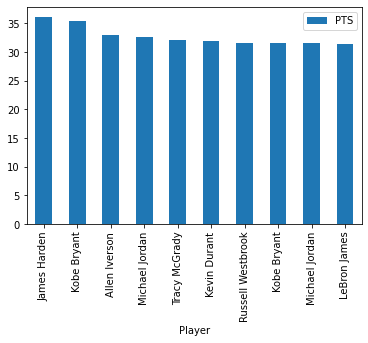

In [48]:
highest_scorer.plot.bar('Player', 'PTS')

In [50]:
highest_scoring = stats.groupby('Year').apply(lambda x: x.sort_values('PTS', ascending=False).head(1))

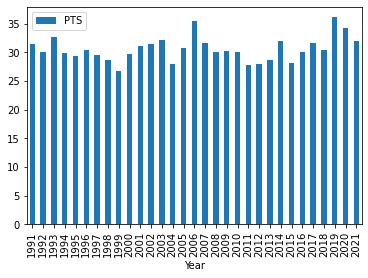

In [51]:
highest_scoring.plot.bar('Year', 'PTS')

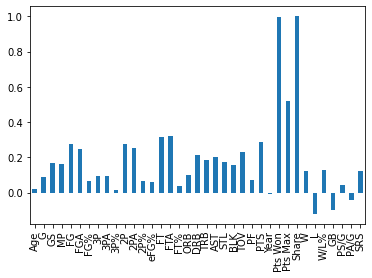

In [54]:
stats.corr()['Share'].plot.bar() # gives us confidence that ML can help for predictions